In [99]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [140]:
path = '/Volumes/LaCie/Work/data/era5/DJF_1981_2023_daily_means/'

sst = xr.open_dataset(path + 'sea_surface_temperature_2010_DJF.nc')
wind = xr.open_dataset(path + 'winds_2010_DJF.nc')
sic = xr.open_dataset(path + 'sea_ice_cover_2010_DJF.nc')

shf = xr.open_dataset(path + 'sensible_heat_flux_2010_DJF.nc')

In [141]:
sst = sst.load()
wind = wind.load()
sic = sic.load()
shf = shf.load()

In [143]:
ws = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, wind)
sst = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, sst.sst)
shf = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, shf.sshf)


In [102]:
# Define the dimensions
time_dim = 90
lat_dim = 201
lon_dim = 1440

# Generate latitude values (assuming they are evenly spaced from -90 to 90 degrees)
latitudes = sst['latitude'].data

# Calculate the Coriolis parameter (f) for each latitude
omega = 7.2921e-5  # Earth's angular velocity in rad/s
f = 2 * omega * np.sin(np.deg2rad(latitudes))

# Expand f to match the dimensions of the dataset (time, latitude, longitude)
f_expanded = np.tile(f, (time_dim, lon_dim, 1)).transpose(0, 2, 1)

# Print the shape of the expanded Coriolis parameter array to verify
print(f_expanded.shape)

(90, 201, 1440)


In [104]:
# Create the xarray Dataset
ds = xr.Dataset(
    {
        'f': (['time', 'latitude', 'longitude'], f_expanded),
        'u_wind': (['time', 'latitude', 'longitude'], ws.u10.data),
        'v_wind': (['time', 'latitude', 'longitude'], ws.v10.data),
        'sst': (['time', 'latitude', 'longitude'], sst.data)
    },
    coords={
        'time': sst['time'].data,
        'latitude': sst['latitude'].data,
        'longitude': sst['longitude'].data
    }
)

In [105]:
from functions import windstress

tau_x = windstress.stress(ds['u_wind'], z=10., drag='largepond', rho_air=1.22, Ta=3.)
tau_y = windstress.stress(ds['v_wind'], z=10., drag='largepond', rho_air=1.22, Ta=3.)

In [106]:
ds['tau_x'] = (('time', 'latitude', 'longitude'), tau_x)
ds['tau_y'] = (('time', 'latitude', 'longitude'), tau_y)

$$ \text{Ekman Heat Flux} = \frac{1}{\rho \cdot C_p} \left( U_E \cdot \Delta \text{SST} \right) $$

In [134]:
# Define the function to calculate Ekman heat flux
def calculate_ekman_heat_flux(ds):
    """
    Calculate Ekman heat flux using the xarray dataset with parameters f, tau_x, tau_y, and sst.
    
    Parameters:
    ds (xarray.Dataset): The input dataset containing 'f', 'tau_x', 'tau_y', and 'sst'.
    
    Returns:
    xarray.DataArray: The Ekman heat flux.
    """
    # Extract parameters from the dataset
    f = ds['f']
    tau_x = ds['tau_x']
    tau_y = ds['tau_y']
    sst = ds['sst']
    
    # Constants
    rho = 1027  # Ocean density in kg/m^3
    Cp = 3985  # Specific heat capacity of seawater in J/(kg·K)
    
    # Calculate Ekman transport components
    U_ek_x = tau_y / (rho * f)
    U_ek_y = -tau_x / (rho * f)
    
    # Calculate the gradient of SST
    dSST_dx = np.gradient(sst, axis=2)/27798
    dSST_dy = np.gradient(sst, axis=1)/27798
    
    # Calculate Ekman heat flux
    ekman_heat_flux = (Cp * rho) * (U_ek_x * dSST_dx + U_ek_y * dSST_dy)
    
    return ekman_heat_flux

# Calculate Ekman flux
ekman_flux_ds = calculate_ekman_heat_flux(ds)

ds['ekman_flux'] = (('time', 'latitude', 'longitude'), ekman_flux_ds.data)

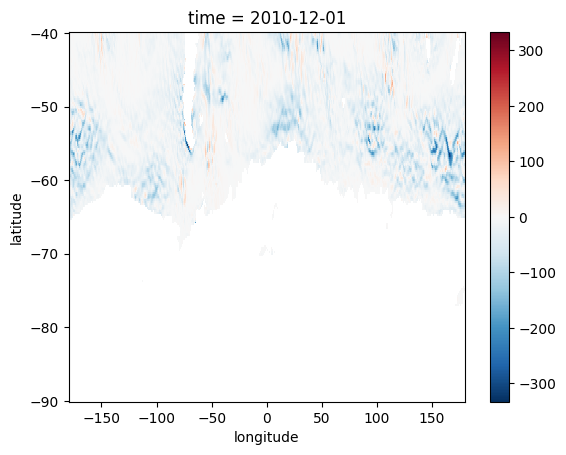

In [131]:
ekman_flux_ds.isel(time=0).plot()

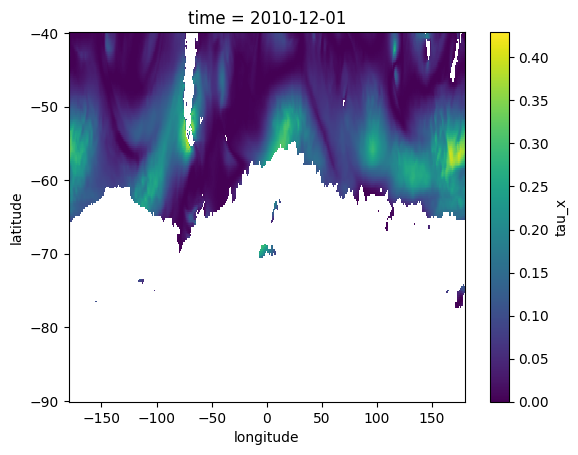

In [ ]:
ds['tau_x'].isel(time=0).plot()

In [145]:
cumulative_integrated_ek = ds['ekman_flux'].sum('time')
cumulative_integrated_shf = shf.sum('time')

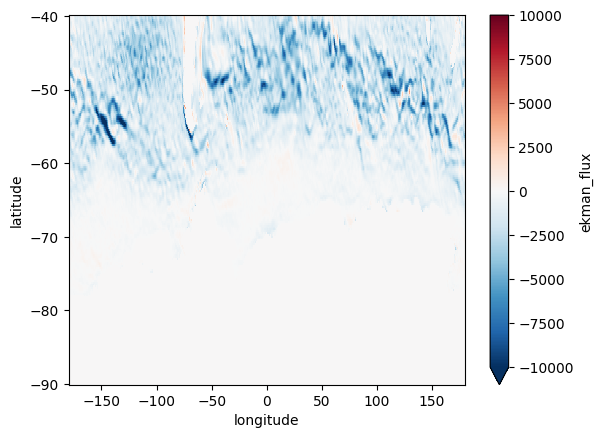

In [149]:
cumulative_integrated_ek.plot(vmin=-10000, vmax=10000, cmap='RdBu_r')

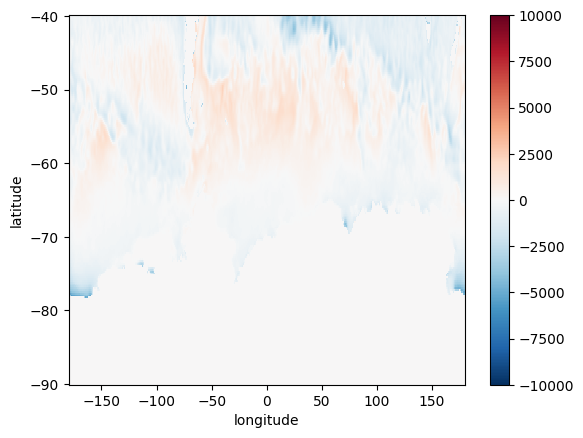

In [151]:
cumulative_integrated_shf.plot(vmin=-10000, vmax=10000, cmap='RdBu_r')